In [1]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## Prep the data

In [3]:
df = pd.read_csv(path/'train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [5]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master")).value_counts(dropna=False)

add_features(df)

In [6]:
splits = RandomSplitter(seed=42)(df)

In [7]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

## Train the model

In [8]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.0831763744354248, valley=0.007585775572806597)

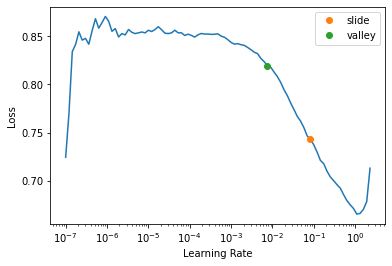

In [9]:
learn.lr_find(suggest_funcs=(slide, valley))

In [46]:
learn.fit(10, lr=0.06)

epoch,train_loss,valid_loss,accuracy,time
0,0.368833,0.445953,0.803371,00:00
1,0.362809,0.414371,0.837079,00:00
2,0.352999,0.424518,0.820225,00:00
3,0.349426,0.474784,0.808989,00:00
4,0.352012,0.453767,0.814607,00:00
5,0.356536,0.459774,0.825843,00:00
6,0.355910,0.475477,0.820225,00:00
7,0.353056,0.497063,0.820225,00:00
8,0.347965,0.442165,0.803371,00:00
9,0.348076,0.459184,0.808989,00:00


## Submit to Kaggle

In [11]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [12]:
tst_dl = learn.dls.test_dl(tst_df)

In [13]:
preds,_ = learn.get_preds(dl=tst_dl)

In [14]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [15]:
!head sub.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Ensembling

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

## Final thoughts